In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

In [2]:
dt = pd.read_csv('train.csv')

Вообще говоря, данные надо предобработать, заменить null или NaN на что-то правильное.
Но в задании задании это можно опустить, т.к. встроенные вычислительные функции могут игнорировать такие значение.

Стоит учесть в "промышленном" применении так делать не стоит.

In [3]:
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
dt.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Матрица корреляций

Вообще, по-хорошему надо ещё учитывать, что корреляция может быть стат значимой и незначимой.
И просто смотреть на матрицу корреляций не очень правильно.
Плюс, есть матрица частных коэффициентов корреляции и ещё корреляции Спирмена для ординальных переменных. 

Но это все тонкости и детали. Другой вопрос в том, для каких переменных проверять корреляцию.

Есть 7 числовых переменных: 
1. PassengerId - Id пассажира, 
2. Survived - метка выжил или нет, 
3. Pclass - класс пассажира, 1 - высший, 3 - низший),
4. Age - возраст для всех, кто старше одного года - кол-во полных лет, для остальных - дробь
5. SibSp - кол-во братьев, сестер(сводных и родных) и супругов на борту
6. Parch - кол-во родителей и детей на борту
7. Fare - плата за проезд

Из описания сразу видно, что PassengerId и Survived имеет смысл откинуть, потому что id нет смысла анализировать, а для анализа связи с меткой необходимо воспользоваться другими методами или вообще просто классификацию делать.
Для Pclass подойдет коэффициент корреляции Спирмена, потому что значения можно упорядочить 1>2>3, но в задаче требудется только коэффициент корреляции Пирсона, так что откинем.

Для остальных уже имеет смысл строить матрицу корреляций

In [39]:
dt[['Age','SibSp','Parch','Fare']].corr()

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


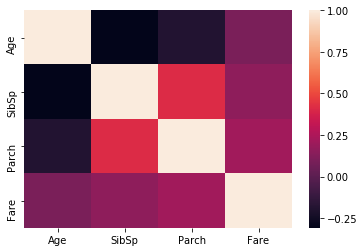

In [40]:
#Just because I can
sns.heatmap(dt[['Age','SibSp','Parch','Fare']].corr())
plt.show()

In [7]:
#More sexy heatmap
dt[['Age','SibSp','Parch','Fare']].corr()\
    .style.set_properties(**{'color':'black'})\
    .background_gradient(cmap='coolwarm').set_precision(2)

,Age,SibSp,Parch,Fare
Age,1,-0.31,-0.19,0.096
SibSp,-0.31,1,0.41,0.16
Parch,-0.19,0.41,1,0.22
Fare,0.096,0.16,0.22,1


## Гистограммы


В статистике гистограммы используют для вызуального представления функции плотности вероятности случайной величины, построенной по выборке.

Вполне логично было бы построить их только для переменных, которые были использованы для построения матрицы корреляции. Но это не очень интересно, поэтому для для других переменных будет построена столбчатая диаграмма

In [51]:
#Будет одна красивая функция, которая будет рисовать все графики вместо кучи однотипного кода
#Но т.к. не все грфики гистограммы, а хочется, чтобы было красиво
#Для этого будет параметр graph_type, который будет говорить о том, какой тип графика строить
#В целом, если добавить ещё значений кроме "hist" и "bar", 
#то в функцию можно просто добавить ещё один блок для новых видов графиков
def super_plot_with_subplts(data, columns_list, nrows, ncols, graph_types):
    fig, ax = plt.subplots(nrows = nrows, ncols =ncols, figsize =(20,20))
    for i in range(0, nrows):
        for j in range(0, ncols):
            col_name = columns_list.pop(0)
            graph_type = graph_types.pop(0)
            if graph_type == 'hist':
                ax[i,j].hist(data[col_name])
            if graph_type == 'bar':
                groups = data.groupby(col_name)[col_name].count().to_dict()
                ax[i,j].bar(x = list(groups.keys()), height = list(groups.values()))
            ax[i,j].set_title(col_name)
    plt.show()

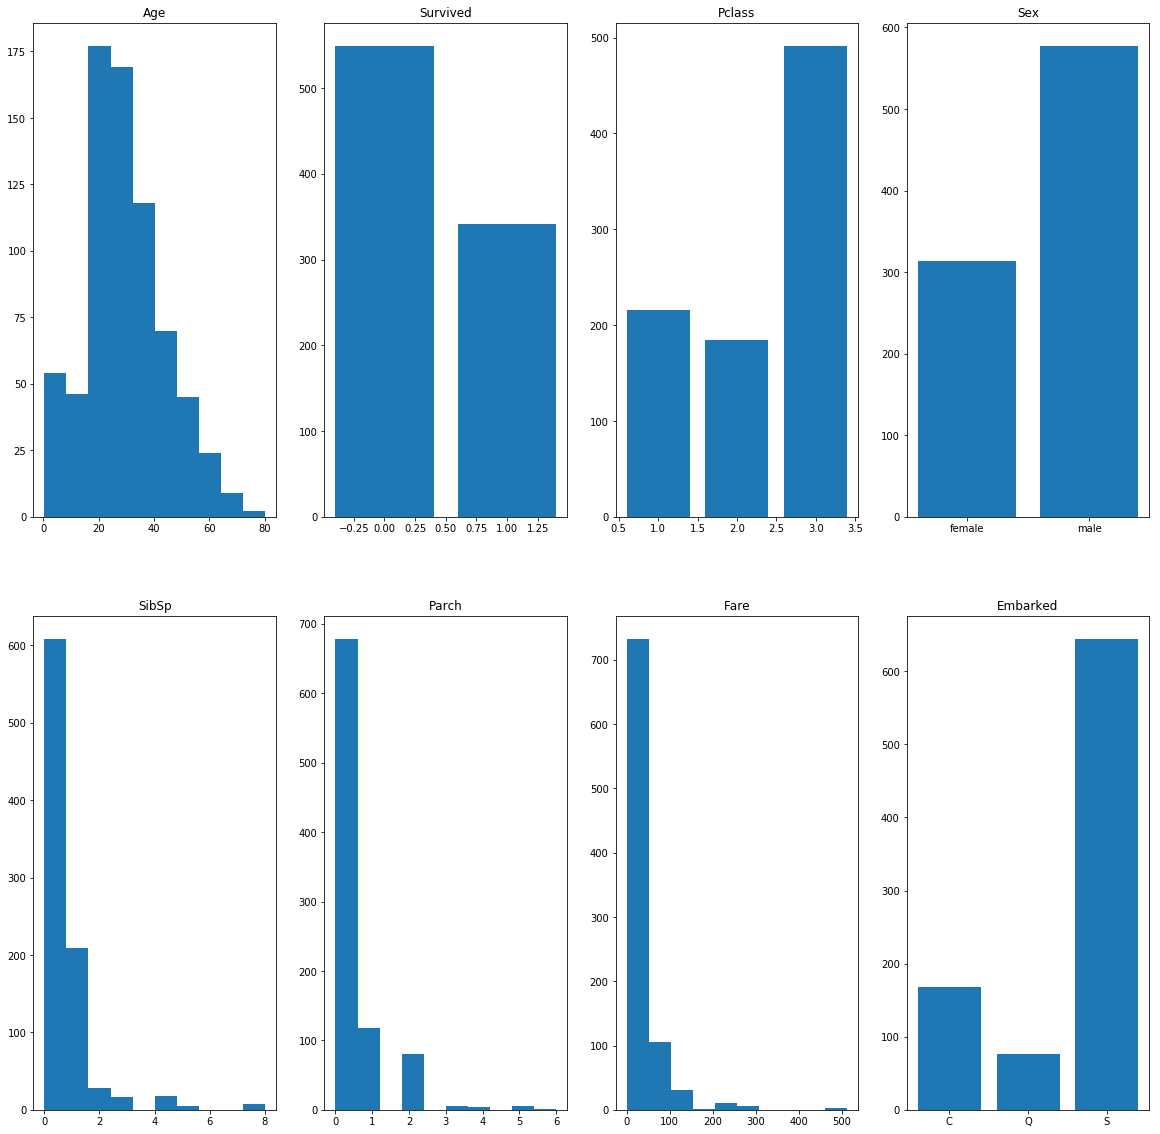

In [52]:
col_names = ['Age','Survived', 'Pclass','Sex','SibSp','Parch','Fare','Embarked']
graph_types = ['hist', 'bar', 'bar', 'bar', 'hist', 'hist', 'hist', 'bar']
super_plot_with_subplts(data=dt,columns_list=col_names,nrows=2,ncols=4, graph_types=graph_types)

## Посчитать самое популярное женское имя


Вроде тут всё просто: взять тех, кого женский пол(неожиданно, да?) и дальше достать оттуда имя и просто посчитать для каждого сколько раз встречается, и вывести самое популярное.

Казалось бы, что тут сложного...

Вообще, дамы делятся на 2 вида: те, кто miss(незамужем) и те, кто mrs(замужем).

Для незамужних структура такая: Фамилия, Miss. Имя. Тут все просто, берем просто все, что после Miss и до первого пробела.
С замужними все сложнее(удивительно, не правда ли?): Фамалия, Mrs. имя мужа(не всегда) (имя и девичья фамилия). Тут надо брать между открывающеся скобочкой и пробельчиком.

Возможны случаи двойного имени(Lily May) или более сложного, с таким можно борорться 2 способами: взять все что между открывающейся скобочкой и последним побелом или забить...

Но тут не идет крутой data science, поэтому будет взято первое имя. Плюс, девушек с двойным именем можно называть только первым именем, так что такое допущение при подсчете законно(но это не точно)

In [68]:
dt[dt['Sex'] == 'female']['Name'].head(15)

1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
18    Vander Planke, Mrs. Julius (Emelia Maria Vande...
19                              Masselmani, Mrs. Fatima
22                          McGowan, Miss. Anna "Annie"
24                        Palsson, Miss. Torborg Danira
25    Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...
28                        O'Dwyer, Miss. Ellen "Nellie"
Name: Name, dtype: object

In [69]:
names = dt[dt['Sex'] == 'female']['Name']

In [243]:
only_names = names.apply(lambda x: x[x.index('. ')+2:].split(" ")[0] if 'Miss' in x 
                            else( x[x.index(' (')+1:].split(" ")[0]  if 'Mrs.' in x and '(' in x 
                                 else x.split(" ")[2]))
#Как оказалось, там не всегда есть скобочка или имя мужа...
#Обрезание лишних скобочек
only_names = only_names.apply(lambda x: x.rstrip(")").lstrip("("))
#То, что написано ниже должно вызывать у тех, кто нормально умеет в питон боль и страдания. 
#И вообще, думаю, что так писать не стоит
only_names = pd.DataFrame(only_names)
only_names = pd.DataFrame({'count':only_names.groupby('Name')['Name'].count()}).reset_index()
print(only_names.sort_values(by = 'count', ascending = False).head(5))

          Name  count
13        Anna     15
144       Mary     14
51   Elizabeth     11
131   Margaret     10
6        Alice      7


## Расчет среднего и медианного возраста


Не самое прикольное задание, но у меня просто написано посчитать это, а кретивить мне лень.

Но можно наложить супер хитрых фильтров, для выделения супер хитрой группы и в ней посчитать это все.
Например, средний возраст несовершеннлолетних(те, кому меньше 18 лет)

In [188]:
print('Средний возраст = {0}'.format(dt['Age'].mean()))
print('Медианный возраст = {0}'.format(dt['Age'].median()))

Средний возраст = 29.69911764705882
Медианный возраст = 28.0


In [11]:
print('Средний возраст несовершеннолетних детей = {0}'.format(dt.query("Age <= 18")['Age'].mean()))
print('Медианный возраст несовершеннолетних детей  = {0}'.format(dt.query("Age <= 18")['Age'].median()))

Средний возраст несовершеннолетних детей = 10.71705035971223
Медианный возраст несовершеннолетних детей  = 13.0


## Анализ пассажиров с разбиением по городу посадки.

На просто наложить какой-нибудь интересный фильтр на пассажиров, разбить их по городам и посчитать.
Например, можно посчитать кол-во незамужних дам из первого класса в каждом городе.

In [32]:
filter = dt[dt['Sex'] == 'female']['Name'].apply(lambda x: True if 'Miss' in x else False)
dt.where(filter)\
    .groupby(['Embarked','Pclass'], as_index = False)\
    .aggregate({'PassengerId':'count'})\
    .rename(columns={'PassengerId':'Passenger_count'})
#Таким образом если можно узнать сколько бы людей выжило, если бы они не зашли на борт или вышли в порту

,Embarked,Pclass,Passenger_count
0,C,1.0,21
1,C,2.0,3
2,C,3.0,14
3,Q,1.0,1
4,Q,2.0,2
5,Q,3.0,30
6,S,1.0,23
7,S,2.0,29
8,S,3.0,58


## Доп бонус

Случайно нашел интересную библиотеку, которая может ускорить разведочный анализ(по словам авторов).

В статье показана одна функция, которая делают весьма простую и красивую вещь.
И это надо видеть)))

In [12]:
#Prepare for something sexy and possibly unuseful:D
pp.ProfileReport(dt)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0
